# Using the Astra "best", a.k.a. "MWMLite", file

## Learning Goals
By the end of this tutorial, you will:
- Know which pipelines are used in the astraMWMLite file
- Understand which pipelines solve different types of stars

## Introduction
While stellar BOSS spectra have been taken in the past, prior to SDSS V no dedicated SDSS analysis pipeline products were released for BOSS spectra of stars. Optical stellar spectra are a major component of SDSS V, so multiple BOSS pipeline products are being released, along with new APOGEE pipelines.

In this short tutorial we will briefly describe six major stellar pipelines for SDSS V data.

## Imports
This tutorial requires two commonly used python packages, and an SDSS specific package
- _matplotlib_ for plotting
- _numpy_ for doing array operations
- _fitsio_ for reading fits table^

Missing packages can be installed via `pip install matplotlib numpy fitsio` 

^Note for Windows users: you may need to use astropy instead

^Note for Linux users: you may have to install a devtools package to compile _fitsio_

In [1]:
import fitsio
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import numpy as np

If you have good internet access and space on your computer, you may download the MWMlite summary file. It is approximately 850 MB in size and can be downloaded from 
https://dr19.sdss.org/sas/dr19/spectro/astra/0.6.0/summary/astraMWMLite-0.6.0.fits.gz

Otherwise, we recommend running this notebook on SciServer.

`fname` below is set assuming the file is in the same directory as this notebook. If your file is in a different place you should modify that variable appropriately. 

If you are running on SciServer you can uncomment the longer file name.

Running the next cell will load the data into memory. Due the file's size this may take a few minutes.

In [2]:
fname = "astraMWMLite-0.6.0.fits.gz"

# fname = "/home/idies/workspace/sdss_sas/dr19/spectro/astra/0.6.0/summary/astraAllStarASPCAP-0.6.0.fits.gz"

lite = fitsio.read(fname)

The purpose of the MWMLite file is to report results from the best pipeline for each star. Hence, every entry in the MWMLite file identifies which pipeline the parameters came from. Below, we show all available pipelines.

In [3]:
pipelines = np.unique(lite["pipeline"])
print(pipelines)

['apogee_net' 'aspcap' 'astro_nn' 'boss_net' 'slam' 'snow_white']


## SDSS V pipelines

A full description of these pipelines is provided at dr19.sdss.org

### ASPCAP

ASPCAP was developed in previous SDSS iterations to handle APOGEE spectra. It was originally developed for the red giant stars originally targeted by APOGEE.

The ASPCAP_FLAG parameter from SDSS IV is now provided as spectrum_flag in the mwm_lite file, so we can make use of the flags from [SDSS IV](https://www.sdss4.org/dr17/irspec/apogee-bitmasks/#AspcapBitMask) to clean the data bit.

### Astro NN

A neural network trained for APOGEE data using well calibrated stars as labels, initially released during SDSS IV.

### APOGEE Net

Another neural network for APOGEE stars, new in SDSS V.

### Slam

A new pipeline developed for APOGEE m-dwarfs, new in SDSS V.

### BOSS Net

A neural network trained for BOSS stars, new in SDSS V.

### Snow White

Our new white dwarf pipelines! Provides WD classification and Log(g) and Teff for DA dwarfs.

## Plotting

Now that we have a general idea of what each pipeline does, how does the Kiel diagram look for the four APOGEE pipelines?

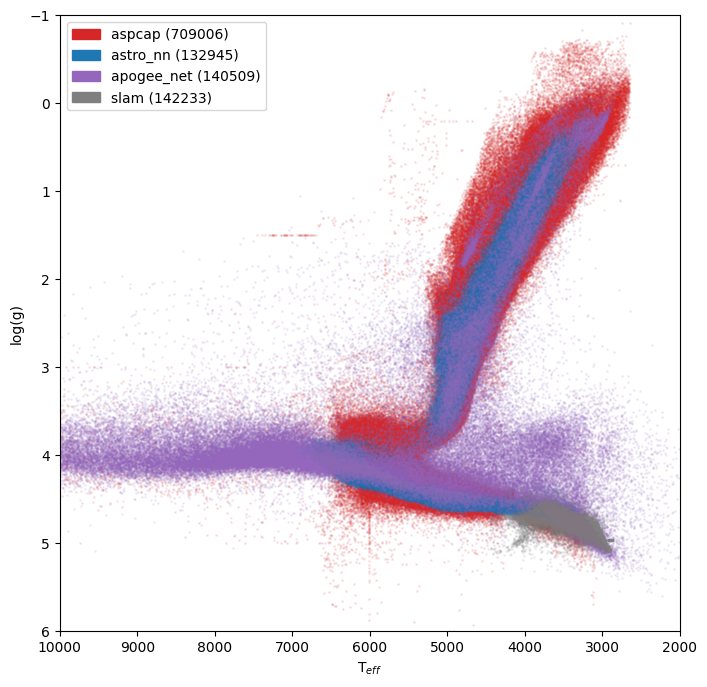

In [4]:
apogee_pipelines = ["aspcap", "astro_nn", "apogee_net", "slam"]

plt.figure(figsize=(8,8))
legend_elements = []
for p, c in zip(apogee_pipelines, ["tab:red", "tab:blue", "tab:purple", "tab:gray"]):
    wsub = lite["pipeline"] == p

    sub = lite[np.where(wsub)]
    if p == "aspcap":
        # 17 is logg bad, 16 is teff
        sub = sub[np.logical_and(sub['spectrum_flags'] & 2**17 == 0, sub['spectrum_flags'] & 2**16 == 0)]        
    label = f"{p} ({len(sub)})"

    plt.scatter(sub["teff"], sub["logg"], s=1, color=c, label=label, alpha=0.1)
    legend_elements.append(Circle(0,radius=1,facecolor=c, edgecolor=c, label=label))
plt.ylim([6, -1])
plt.xlim([10000, 2000])
plt.xlabel(r"T$_{eff}$")
plt.ylabel("log(g)")
# plt.legend()

plt.gca().legend(handles=legend_elements, loc='upper left')

The figure clearly shows the wide parameter space where ASPCAP and astro_nn perform well, a clump of stars where the Slam is very effective, and the long, hot tail where APOGEE Net is able to solve stars too hot for other pipelines.

Now we'll split them out and add a metallicity colorbar.

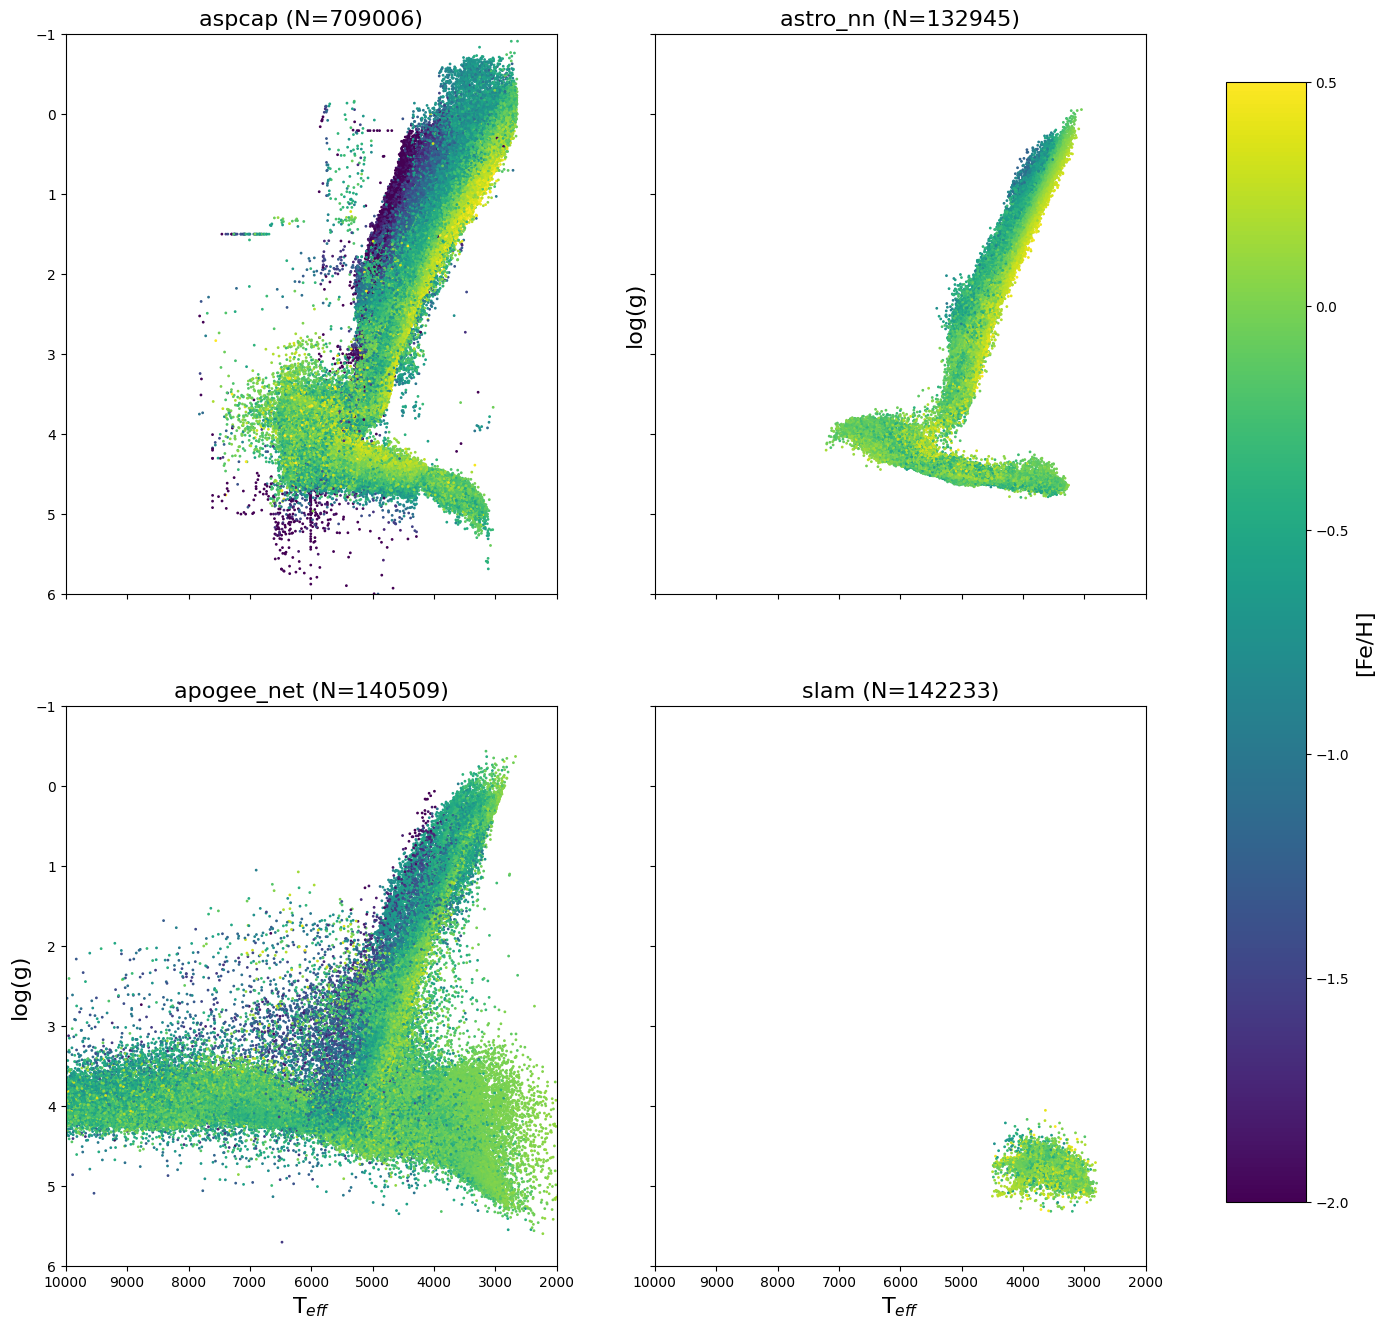

In [5]:
fig, all_axes = plt.subplots(2, 2, figsize=(16, 16), sharex=True, sharey=True)
axes = all_axes.flatten()
for p, ax in zip(apogee_pipelines, axes):
    wsub = lite["pipeline"] == p

    sub = lite[np.where(wsub)]

    if p == "aspcap":
        # 17 is logg bad, 16 is teff
        sub = sub[np.logical_and(sub['spectrum_flags'] & 2**17 == 0, sub['spectrum_flags'] & 2**16 == 0)]
    label = f"{p} (N={len(sub)})"

    im = ax.scatter(sub["teff"], sub["logg"], s=1, c=sub["fe_h"], vmin=-2, vmax=0.5)
    ax.set_title(label, fontsize=16)
    ax.set_ylim([6, -1])
    ax.set_xlim([10000, 2000])
axes[-1].set_xlabel(r"T$_{eff}$", fontsize=16)
axes[-2].set_ylabel("log(g)", fontsize=16)

axes[-2].set_xlabel(r"T$_{eff}$", fontsize=16)
axes[1].set_ylabel("log(g)", fontsize=16)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(label='[Fe/H]', fontsize=16)

## BOSS Pipelines

The BOSS spectrograph is able to observe stars much dimmer and bluer than APOGEE. We can plot a Kiel diagram for all the BOSS stars solved by BOSS net to see the wide variation in parameter space.

Finally, Snow White is able to solve Log(g) and Teff for DA white dwarfs.

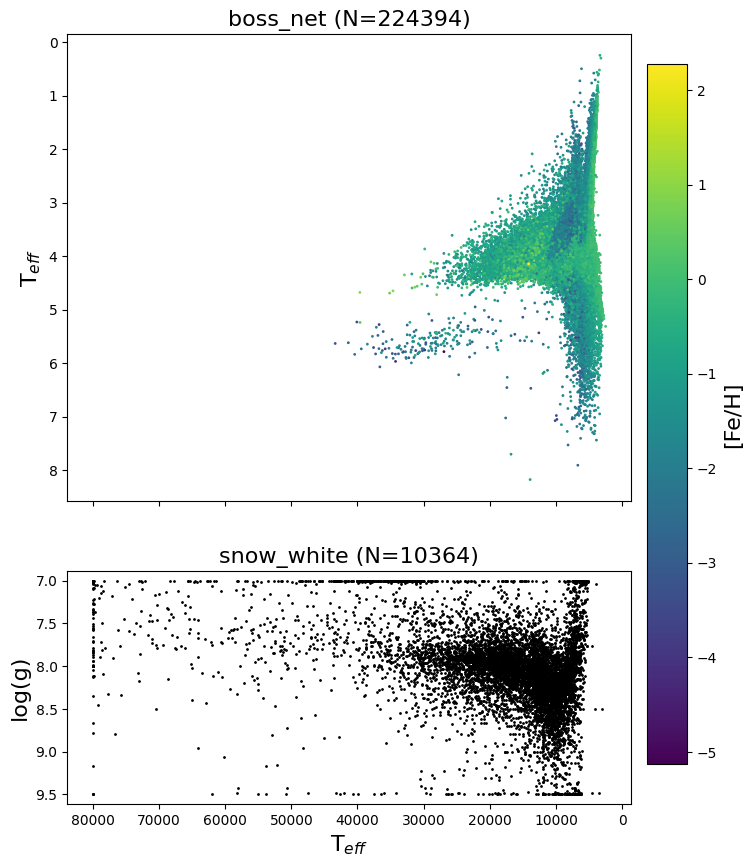

In [6]:
fig, all_axes = plt.subplots(2, 1, figsize=(8, 10), sharex=True, height_ratios=[2,1])
ax1, ax2 = all_axes.flatten()

wsub = lite["pipeline"] == "boss_net"
sub = lite[np.where(wsub)]
im = ax1.scatter(sub["teff"], sub["logg"], s=1, c=sub["fe_h"])

label = f"boss_net (N={len(sub)})"
ax1.set_title(label, fontsize=16)

wsub = lite["pipeline"] == "snow_white"
sub = lite[np.where(wsub)]
ax2.scatter(sub["teff"], sub["logg"], s=1, color="k")

label = f"snow_white (N={len(sub)})"
ax2.set_title(label, fontsize=16)

ax1.xaxis.set_inverted(True)
ax2.xaxis.set_inverted(True)
ax1.yaxis.set_inverted(True)
ax2.yaxis.set_inverted(True)

ax2.set_xlabel(r"T$_{eff}$", fontsize=16)
ax2.set_ylabel("log(g)", fontsize=16)

ax1.set_ylabel(r"T$_{eff}$", fontsize=16)

fig.subplots_adjust(right=0.83)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(label='[Fe/H]', fontsize=16)

## Other white dwarfs

While Log(g) and Teff are only provided for DA stars, snow white provides a classification for all WDs. Confidence estimates for these classifications are included, see the data model for details.

In the absence of stellar parameters, a Gaia HR diagram can be created for the WDs, color coded by classification.

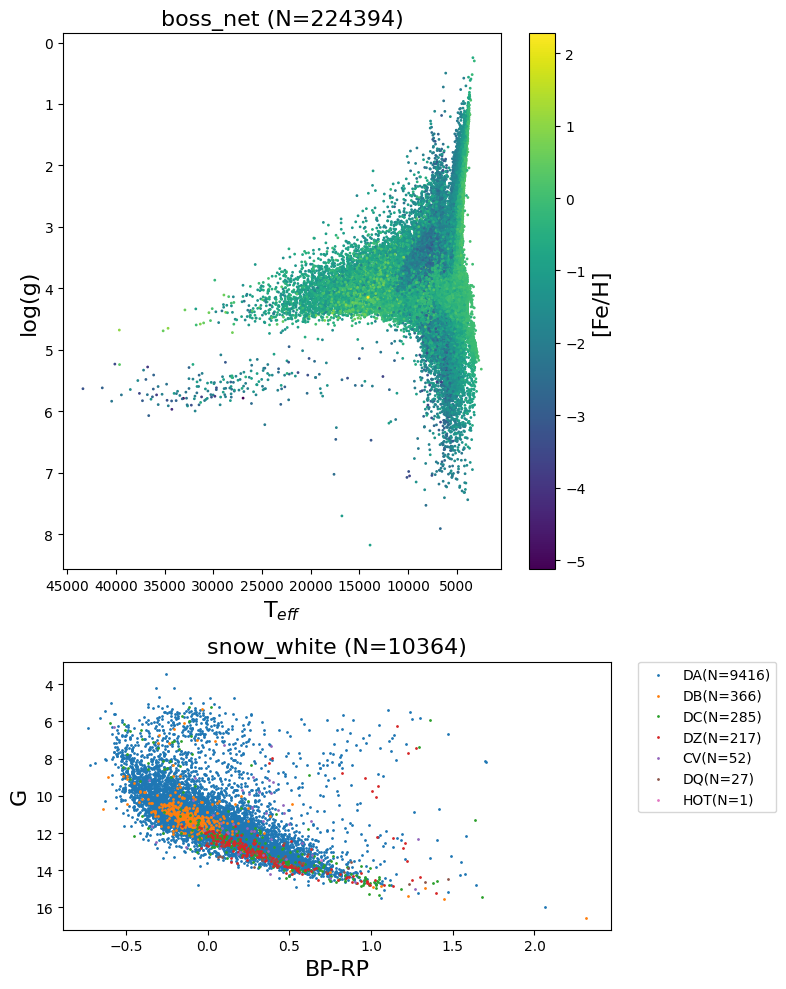

In [7]:
def translate(label):
    return label.upper().strip("[]/'_")[:2]

fig, all_axes = plt.subplots(2, 1, figsize=(8, 10), height_ratios=[2,1])
ax1, ax2 = all_axes.flatten()

wsub = lite["pipeline"] == "boss_net"
sub = lite[np.where(wsub)]
im = ax1.scatter(sub["teff"], sub["logg"], s=1, c=sub["fe_h"])

label = f"boss_net (N={len(sub)})"
ax1.set_title(label, fontsize=16)

cbar = fig.colorbar(im, ax=ax1)
cbar.set_label(label='[Fe/H]', fontsize=16)

wsub = lite["pipeline"] == "snow_white"
sub = lite[np.where(wsub)]
labels = np.array([translate(s) for s in sub["classification"]])
ulabels, counts = np.unique(labels, return_counts=True)

ulabels = ulabels[np.flip(np.argsort(counts))]

for l in ulabels:
    wl = np.where(labels == l)
    subsub = sub[wl]
    if l == "HO":
        l = "HOT"
    l = l + f"(N={len(subsub)})"
    if len(subsub) < 1000:
        s = 10
    else:
        s = 1
    G = subsub['g_mag'] - (5 * np.log10(subsub["r_med_geo"])) + 5
    ax2.scatter(subsub["bp_mag"] - subsub["rp_mag"], G, s=1, label=l)

label = f"snow_white (N={len(sub)})"
ax2.set_title(label, fontsize=16)

ax1.xaxis.set_inverted(True)
# ax2.xaxis.set_inverted(True)
ax1.yaxis.set_inverted(True)
ax2.yaxis.set_inverted(True)

ax1.set_xlabel(r"T$_{eff}$", fontsize=16)
ax1.set_ylabel("log(g)", fontsize=16)
ax2.set_xlabel("BP-RP", fontsize=16)
ax2.set_ylabel("G", fontsize=16)

ax2.legend(bbox_to_anchor=(1.05, 1),
           loc='upper left', borderaxespad=0.)
plt.tight_layout()

# Putting it all together

To see the full MWM DR 19 picture, we can create a Kiel diagram combining BOSS and APOGEE data

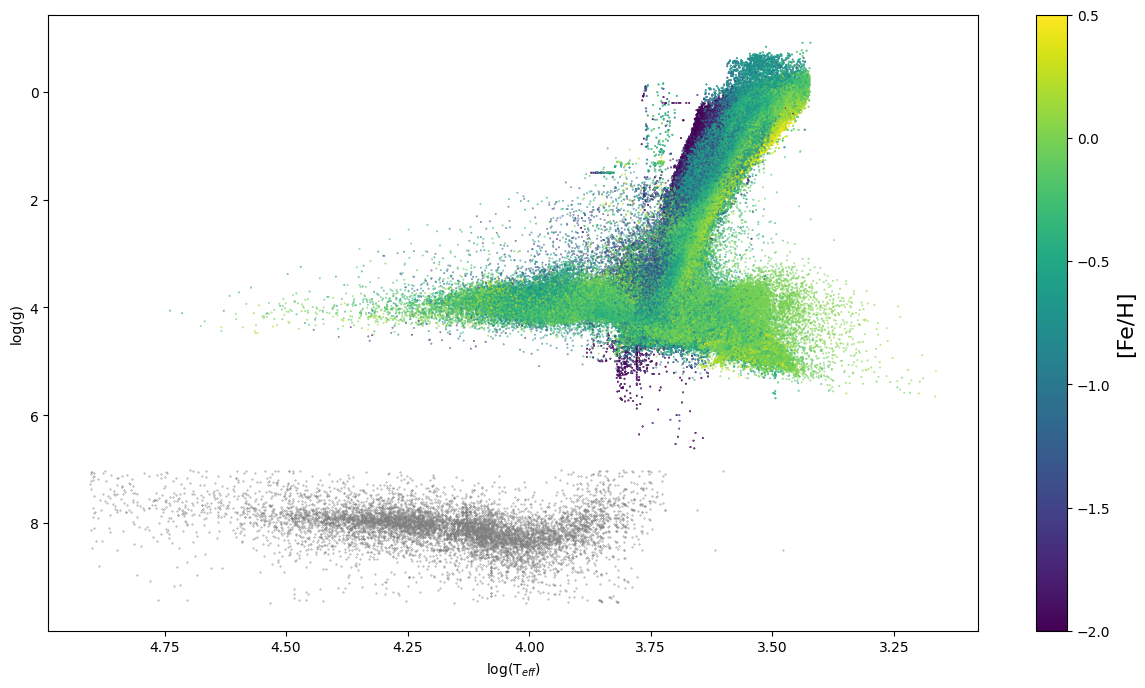

In [8]:
pipelines = ["aspcap", "astro_nn", "apogee_net", "slam", "snow_white"]

fig = plt.figure(figsize=(15, 8))
for p in pipelines:
    wsub = lite["pipeline"] == p

    sub = lite[np.where(wsub)]

    size = 0.1

    if p == "aspcap":
        # 17 is logg bad, 16 is teff
        sub = sub[np.logical_and(sub['spectrum_flags'] & 2**17 == 0, sub['spectrum_flags'] & 2**16 == 0)]

        plt.scatter(np.log10(sub["teff"]), sub["logg"], s=size, c=sub["fe_h"], vmin=-2, vmax=0.5)
    if p == "snow_white":
        # there are grid edges at  7.0 and 9.49 for log(g), 
        # and 80,000K for Teff so make sure we aren't too close
        catch_edges = np.where((np.abs(sub["logg"] - 7.01) > 0.01) 
                               & (np.abs(sub["logg"] - 9.49) > 0.01)
                               & (np.abs(sub["teff"] - 80000) > 100))
        sub = sub[catch_edges]
        plt.scatter(np.log10(sub["teff"]), sub["logg"], s=size, c="tab:gray")
    else:
        im = plt.scatter(np.log10(sub["teff"]), sub["logg"], s=size, c=sub["fe_h"], vmin=-2, vmax=0.5)
# plt.ylim([6, -1])
# plt.xlim([10000, 2000])
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.xlabel(r"log(T$_{eff}$)")
plt.ylabel("log(g)")
cbar = fig.colorbar(im)
cbar.set_label(label='[Fe/H]', fontsize=16)

## About this notebook
This notebook was created to explore the mwm-lite summary file.

**Authors**: John Donor

**Last Update**: 2025 June 24

Please [cite](https://sdss.org/collaboration/citing-sdss/) SDSS when you use our data.